# Problem Statement:


In today's digital age, online shopping has become the go-to option for many consumers. However, the overwhelming number of choices and the lack of personalized assistance can make the shopping experience daunting. To address this, we have developed FashionFinder AI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery.


**Given a dataset containing information about fashion products (product names, specifications, descriptions, etc.), build a chatbot that parses the dataset and provides accurate fashion recommendations based on user requirements. bold text**

## Part 1 : System Architecture

The chatbot should ask a series of questions to:

Determine the user's requirements. For simplicity, we have used 4 features to encapsulate the user's needs. The 4 features are as follows:


*   Price
*   Colour
*   Rating
*   Gender

Confirm if the user's requirements have been correctly captured at the end.

After that, the chatbot lists down the top 3 products that are the most relevant and engages in further conversation to help the user find the best one.
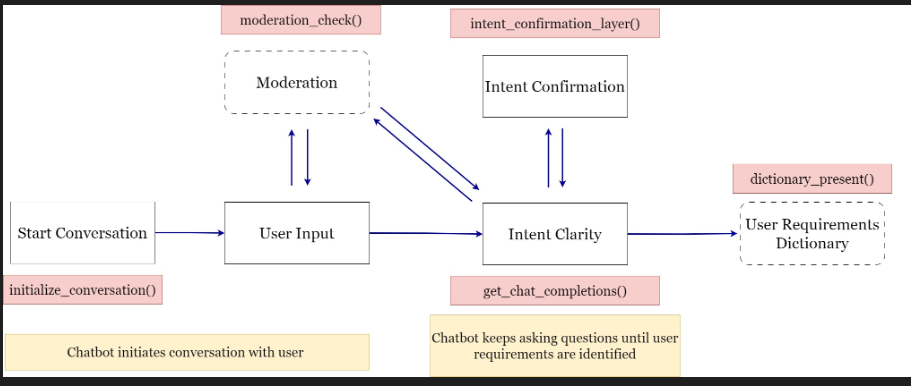

## Part 2 : Solution POC

|`Stage 1`

- Intent Clarity Layer
- Intent Confirmation Layer

`Stage 2`

- Product Mapping Layer
- Product Information Extraction Layer

`Stage 3`

- Product Recommendation Layer

##### Major functions behind the Chatbot

Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later



- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not.
- `dictionary_present()`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_laptops_with_user()`: This function compares the user's profile with the different products and come back with the top 3 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

### 2.1 Import necessary Libraries

In [1]:
# Install OpenAI, LlamaIndex
!pip install llama-index faiss-cpu openai pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.6 MB/s eta 0:00:00


In [2]:
## Install additional supporting libraries as required
import pandas as pd
from llama_index.core import  Document,VectorStoreIndex, ServiceContext, SimpleDirectoryReader

In [3]:
# Importing the libraries

from llama_index.llms.openai import OpenAI
from tenacity import retry, wait_random_exponential, stop_after_attempt
from llama_index.core.llms import ChatMessage
from llama_index.core.node_parser import SimpleFileNodeParser
from IPython.display import display, HTML
# Set the display width to control the output width
pd.set_option('display.width', 100)
import os, json
import openai
import pandas as pd

### 2.2 Mount Google Drive and set the API key

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/MyDrive/FashionSearchAI')
!ls

 ChromaDB_Data	        Fashion_Search_AI__Ipsita_Pal.ipynb   OpenAI_API_key.txt
 downloaded_image.jpg   FashionSearchAI_latest.ipynb
 FashionDataset.csv    'FashionSearchAI (V1).ipynb'


In [6]:
# Read the OpenAI API key
openai.api_key = open("OpenAI_API_key.txt", "r").read().strip()
os.environ['OpenAI_API_key'] = openai.api_key

### 2.3 Data Loading

In [7]:
# Read the dataset and read the product Dataset
df = pd.read_csv('FashionDataset.csv')
df.head()

,Unnamed: 0,p_id,name,price,colour,brand,img,ratingCount,avg_rating,description,p_attributes
0,0,17048614.0,Khushal K Women Black Ethnic Motifs Printed Ku...,5099.0,Black,Khushal K,http://assets.myntassets.com/assets/images/170...,4522.0,4.418399,Black printed Kurta with Palazzos with dupatta...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
1,1,16524740.0,InWeave Women Orange Solid Kurta with Palazzos...,5899.0,Orange,InWeave,http://assets.myntassets.com/assets/images/165...,1081.0,4.119334,Orange solid Kurta with Palazzos with dupatta<...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
2,2,16331376.0,Anubhutee Women Navy Blue Ethnic Motifs Embroi...,4899.0,Navy Blue,Anubhutee,http://assets.myntassets.com/assets/images/163...,1752.0,4.161530,Navy blue embroidered Kurta with Trousers with...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
3,3,14709966.0,Nayo Women Red Floral Printed Kurta With Trous...,3699.0,Red,Nayo,http://assets.myntassets.com/assets/images/147...,4113.0,4.088986,Red printed kurta with trouser and dupatta<br>...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
4,4,11056154.0,AHIKA Women Black & Green Printed Straight Kurta,1350.0,Black,AHIKA,http://assets.myntassets.com/assets/images/110...,21274.0,3.978377,"Black and green printed straight kurta, has a ...","{'Body Shape ID': '424', 'Body or Garment Size..."


In [8]:
df.columns

Index(['Unnamed: 0', 'p_id', 'name', 'price', 'colour', 'brand', 'img', 'ratingCount',
       'avg_rating', 'description', 'p_attributes'],
      dtype='object')

In [9]:
#cleaning the dataset by handling nulls
df['ratingCount']=df['ratingCount'].fillna(0)
df['avg_rating']=df['avg_rating'].fillna(0)
df.isnull().sum()
df=df[~df.colour.isnull()]
df.isnull().sum()
## Creating gender column from text data
def getGender(x):

  if 'women' in x.lower():
    return 'women'
  if ' men' in x.lower():
    if 'women' not in x.lower():
      return 'men'
    else:
      return 'men'
  if 'kids' in x.lower():
    return 'kids'


df['Gender']=df['name'].apply(getGender)

<ipython-input-9-5b4f77a8b131>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gender']=df['name'].apply(getGender)


### 2.4 Embed the documents, parse into nodes , Build Index and query engine

In [10]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings

##Initialize the OpenAI model
Settings.llm = OpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=256)

##Initialize the embedding model
Settings.embed_model = OpenAIEmbedding()

## Initialize the node_parser with the custom node settings
Settings.node_parser = SentenceSplitter(chunk_size=512, chunk_overlap=20)

## Initialize the num_output and the context window
Settings.num_output = 512
Settings.context_window = 3900





# Convert the product data into a list of Document objects
documents = [
    Document(
        id=row['p_id'],
        text=row['name'],
        brand=str(row['brand']),
        extra_info={
            'colour': row['colour'],
            'price': row['price'],
            'Gender': row['Gender'],
            'ratingcount': row['ratingCount'],
            'avg_rating': row['avg_rating'],
            'description': row['description']
        }
    )
    for _, row in df.iterrows()
]




# Create a VectorStoreIndex from a list of documents using the service context
index = VectorStoreIndex.from_documents(documents)

# Initialize a query engine for the index with a specified similarity top-k value
query_engine = index.as_query_engine(similarity_top_k=3)

In [11]:
response = query_engine.query("Suggest dress for women in size s?")
response

Response(response='The Sera Women Stylish Black Floral Dress in size S would be a great choice for women looking for a trendy and stylish option.', source_nodes=[NodeWithScore(node=TextNode(id_='06720343-857f-4111-9b8c-5e122c54304b', embedding=None, metadata={'colour': 'Black', 'price': 2998.0, 'Gender': 'women', 'ratingcount': 11.0, 'avg_rating': 2.8181818181818183, 'description': "Spruce up the style of your closet with this trendy dress. It features a floral print and long sleeves that will accentuate your silhouette.&nbsp;<ul><li>Stylish black colour</li><li>Beautiful floral print</li><li>Flounced hemline</li><li>Long puff sleeves</li><li>Polyester, machine wash</li></ul><b>Trend Alert</b><br>Originated in the 18th century, the sweetheart neckline is still a popular fashion choice. It is characterised by the prominent, scalloped shape that resembles the top of a heart. It lengthens the neck and adds balance to the overall silhouette while lending a curvy touch.The model (height 5'8

### 2.5 Implement Intent clarity & Intent confirmation layers

#### Initialize conversation

In [12]:
def initialize_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    delimiter = "####"

    example_user_dict = {'price': 1000,
                        'colour':"red",

                        'avg_rating': 3}

    example_user_req = {'price': "_",
                        'colour': "_",

                        'avg_rating': "_"}

    system_message = f"""
    You are an intelligent fasion search AI and your goal is to find the best fashion product for a user.
    You need to ask relevant questions and understand the user profile by analysing the user's responses.
    You final objective is to fill the values for the different keys ('colour','price','avg_rating') in the python dictionary and be confident of the values.
    These key value pairs define the user's profile.
    The python dictionary looks like this
    {{'colour': 'values','price': 'values','avg_rating': 'values'}}
    The value for 'price' and 'avg_rating' should be a numerical value extracted from the user's response.
    All the values in the example dictionary are only representative values.
    {delimiter}
    Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalised:
    - The value for 'price' should be a numerical value extracted from the user's response.

    - 'price' value needs to be greater than or equal to 170 INR. If the user says less than that, please mention that there are no products in that range.
    - 'avg_rating' needs to range from 1 to 5.
    - 'colour' should be colours.
    Strongly ensure that If the 'colour' value is already provided, do not ask further questions on other shades. Go ahead with the provided colour as it is.
    - Do not randomly assign values to any of the keys.
    - The values need to be inferred from the user's response.
    {delimiter}

    To fill the dictionary, you need to have the following chain of thoughts:
    Follow the chain-of-thoughts below and only output the final updated python dictionary for the keys as described in {example_user_req}. \n
    {delimiter}
    Thought 1: Ask a question to understand the user's profile and requirements. \n
    If their primary use for the product is unclear. Ask followup questions to understand their needs.
    You are trying to fill the values of the keys {{'price','colour','avg_rating'}} in the python dictionary by understanding the user requirements.
    Identify the keys for which you can fill the values confidently using the understanding. \n
    If the user is not specific about 'avg_rating', you can proceed without it.
    Remember the instructions around the values for the different keys.
    If the necessary information has been extracted, only then proceed to the next step. \n
    Otherwise, rephrase the question to capture their profile clearly. \n

    {delimiter}
    Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step.
    Remember the instructions around the values for the different keys.
    For 'price' look up, searc for numerical values in the user input that are closely followed/preceded by words like 'INR' or 'rupees' or 'budget' or 'price' or 'rs
    Ask questions you might have for all the keys to strengthen your understanding of the user's profile.
    If yes, move to the next Thought. If no, ask question on the keys whose values you are unsure of. \n
    It is a good practice to ask question with a sound logic as opposed to directly citing the key you want to understand value for.
    {delimiter}

    {delimiter}
    Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
    If you are not confident about any of the values, ask clarifying questions.
    {delimiter}

    {delimiter}
    Here is a sample conversation between the user and assistant:
    User: "Hi, I am a working women."
    Assistant: "Great! As a working women, you likely require a fashion products that are comfortable and also office wear. Let me know if my understanding is correct until now."
    User: "Yes"
    Assistant: "Thank you for providing that information. Are you lookiong for any specific colour"
    User: "Yes, red"
    Assistant: "Thank you for the information. Processing red office wear products.To ensure I have a complete understanding of your needs, I have one more question: Are you looking at high rated products"
    User: "Yes, I am looking for products rated above 3."
    Assistant:"Could you kindly let me know your price range for the product? This will help me find options that fit within your price range while meeting the specified requirements."
    User: "my max budget is 1000 inr"
    Assistant: "{example_user_dict}"
    {delimiter}
    {delimiter}
    Here is a another ample conversation between the user and assistant:
    User: "Hi, I am looking for activewear for my kids."
    Assistant: "Great! For kids activewear, you likely require a fashion products that are comfortable and vibrant. Let me know if my understanding is correct until now."
    User: "Yes"
    Assistant: "Thank you for providing that information. Are you looking for any specific colour"
    User: "Yes, red"
    Assistant: "Thank you for the information. Processing red active wear products for kids.To ensure I have a complete understanding of your needs, I have one more question: Are you looking at high rated products"
    User: "Yes, I am looking for products rated above 3."
    Assistant:"Could you kindly let me know your price range for the product? This will help me find options that fit within your price range while meeting the specified requirements."
    User: "my max budget is 1000 rs"
    Assistant: "{example_user_dict}"
    {delimiter}
    Start with a short welcome message and encourage the user to share their requirements.
    """
    conversation = [{"role": "system", "content": system_message}]
    # conversation = system_message
    return conversation

In [13]:
debug_conversation = initialize_conversation()
print(debug_conversation)

[{'role': 'system', 'content': '\n    You are an intelligent fasion search AI and your goal is to find the best fashion product for a user.\n    You need to ask relevant questions and understand the user profile by analysing the user\'s responses.\n    You final objective is to fill the values for the different keys (\'colour\',\'price\',\'avg_rating\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'colour\': \'values\',\'price\': \'values\',\'avg_rating\': \'values\'}\n    The value for \'price\' and \'avg_rating\' should be a numerical value extracted from the user\'s response.\n    All the values in the example dictionary are only representative values.\n    ####\n    Here are some instructions around the values for the different keys. If you do not follow this, you\'ll be heavily penalised:\n    - The value for \'price\' should be a numerical value extracted from the 

In [14]:
# Let's initialise conversation
system_message = initialize_conversation()
print(system_message[0]["content"])


    You are an intelligent fasion search AI and your goal is to find the best fashion product for a user.
    You need to ask relevant questions and understand the user profile by analysing the user's responses.
    You final objective is to fill the values for the different keys ('colour','price','avg_rating') in the python dictionary and be confident of the values.
    These key value pairs define the user's profile.
    The python dictionary looks like this
    {'colour': 'values','price': 'values','avg_rating': 'values'}
    The value for 'price' and 'avg_rating' should be a numerical value extracted from the user's response.
    All the values in the example dictionary are only representative values.
    ####
    Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalised:
    - The value for 'price' should be a numerical value extracted from the user's response.

    - 'price' value needs to be greater than or equal

#### Get chat completion

In [15]:
# Define a Chat Completions API call
# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_completions(input, json_format = False):
    MODEL = 'gpt-3.5-turbo'

    system_message_json_output = """<<. Return output in JSON format to the key output.>>"""

    # If the output is required to be in JSON format
    if json_format == True:
        # Append the input prompt to include JSON response as specified by OpenAI
        input[0]['content'] += system_message_json_output

        # JSON return type specified
        chat_completion_json = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            response_format = { "type": "json_object"},
            seed = 1234)

        output = json.loads(chat_completion_json.choices[0].message.content)

    # No JSON return type specified
    else:
        chat_completion = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            seed = 2345)

        output = chat_completion.choices[0].message.content

    return output

In [16]:
# Testing the OpenAI functions defined above
input_prompt ='What is the capital of France?'
messages = [{'role':'user','content':input_prompt}]
# system_message_json_output = """<<. Return output in JSON format.>>"""
# messages[0]['content']+=system_message_json_output
## Get LLM Outputs - normal
get_chat_completions(messages) ## Chat Completions API

'The capital of France is Paris.'

#### Iterate llm response

In [17]:
def iterate_llm_response(funct, debug_response, num = 10):
    """
    Calls a specified function repeatedly and prints the results.
    This function is designed to test the consistency of a response from a given function.
    It calls the function multiple times (default is 10) and prints out the iteration count,
    the function's response(s).
    Args:
        funct (function): The function to be tested. This function should accept a single argument
                          and return the response value(s).
        debug_response (dict): The input argument to be passed to 'funct' on each call.
        num (int, optional): The number of times 'funct' will be called. Defaults to 10.
    Returns:
        This function only returns the results to the console.
    """
    i = 0  # Initialize counter

    while i < num:  # Loop to call the function 'num' times

        response = funct(debug_response)  # Call the function with the debug response

        # Print the iteration number, result, and reason from the response
        print("Iteration: {0}".format(i))
        print(response)
        print('-' * 50)  # Print a separator line for readability
        i += 1  # Increment the counter

In [18]:
debug_user_input = "Hi, I am Anand. I am looking for menswear"
debug_conversation.append({"role": "user", "content": debug_user_input})
# Getting the response from the Assistant by passing the conversation to the Chat Completions API
debug_response_assistant = get_chat_completions(debug_conversation)
display(debug_response_assistant)

'Great! For menswear, you likely require fashion products that are stylish and versatile. Let me know if my understanding is correct until now. \n\nAre you looking for any specific colour in menswear?'

In [19]:
debug_conversation.append(({"role": "system", "content": debug_response_assistant}))

#### Moderation Check

In [20]:
# Define a function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

In [21]:
moderation_check("I want to kill them.")

'Flagged'

#### Intent confimration layer

In [22]:
def intent_confirmation_layer(response_assistant):

    delimiter = "####"



    prompt = f"""
    You are a school girl who likes to dress casually.
    You are provided an input. You need to evaluate if the input text has the following keys:
    {{
    'colour': 'values',
    'price':values,
    'avg_rating':values
    }}

    The 'price' and 'avg_rating' key can take only a numerical value.
    Set 'colour' value from the colour provided in input.

    Next you need to evaluate if the keys have the the values filled correctly.
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output a string 'Yes' if all values are correctly filled for all keys, otherwise output 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    THought 3 - Think carefully before the answering.
    """

    messages=[{"role": "system", "content":prompt },
              {"role": "user", "content":f"""Here is the input: {response_assistant}""" }]

    response = openai.chat.completions.create(
                                    model="gpt-3.5-turbo",
                                    messages = messages,
                                    response_format={ "type": "json_object" },
                                    seed = 1234
                                    # n = 5
                                    )

    json_output = json.loads(response.choices[0].message.content)

    return json_output

In [23]:
debug_response_assistant='Yellow dress at 3 rated and within 500 INR'
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
display(debug_confirmation)

{'result': 'Yes'}

In [24]:
#Let's add the above assistant response to the debug_conversation.
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})

#### check if the Dictionary is present

In [25]:
def dictionary_present(response):
    delimiter = "####"

    user_req = {'colour': 'green',
                'price': 300,
                'avg_rating': 3}

    prompt = f"""You are a python expert. You are provided an input.
            You have to check if there is a python dictionary present in the string.
            It will have the following format {user_req}.
            Your task is to just extract the relevant values from the input and return only the python dictionary in JSON format.
            The output should match the format as {user_req}.

            {delimiter}
            Make sure that the value of price is  present in the user input. ###
            The output should contain the exact keys and values as present in the input.
            If 'avg_rating' value is not given, set it to numerical value 1
            Ensure the keys and values are in the given format:
            {{
            'colour': 'colour options ',
            'price':'numerical value',
            'avg_rating':'numerical value ranging from 1 to 5'
            }}
            Here are some sample input output pairs for better understanding:
            {delimiter}
            input 1: - colour: red  - price: 500 - avg_rating: -
            output 1: {{'colour': 'red', 'price': 300, 'avg_rating': 1}}

            input 1: - colour: yellow  - price: 1500 - avg_rating: 4
            output 1: {{'colour': 'yellow', 'price': 1500, 'avg_rating': 3}}

            input 1: - colour: cyan  - price: 4000 - avg_rating: 5
            output 1: {{'colour': 'cyan', 'price': 4000, 'avg_rating': 3}}
            {delimiter}
            """
    messages = [{"role": "system", "content":prompt },
                {"role": "user", "content":f"""Here is the user input: {response}""" }]

    confirmation = get_chat_completions(messages, json_format = True)

    return confirmation

In [26]:
debug_response_assistant_n = """
{'colour':'white',
 'price':200,
 'avg_rating':'-'}
"""
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)

{'colour': 'white', 'price': 200, 'avg_rating': 1}

In [27]:
debug_conversation = initialize_conversation()
debug_user_input = "Hi, I am looking for schoolwear"
debug_moderation = moderation_check(debug_user_input)
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_completions(debug_conversation)
debug_moderation = moderation_check(debug_response_assistant)
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
# After a series of conversation...
response_dict_n = dictionary_present(debug_response_assistant_n)
print(response_dict_n)

{'colour': 'white', 'price': 200, 'avg_rating': 1}


#### Implement product mapping & information extraction layers

In [28]:
## Not used anywhere, we might use this if we want to extract specific information from dataframe columns
def product_map_layer(product_description):
    delimiter = "#####"

    prod_spec = {
        "colour":"(colour of the product)",
        "price":"(price range of the product)",
        "avg_rating":"(avg_rating values from 1 to 5)"
    }



    prompt=f"""
    You are a product Specifications Classifier whose job is to extract the key features of products and classify them as per their requirements.
    To analyze each product, perform the following steps:
    Step 1: Extract the products primary features from the description {product_description}
    Step 2: Store the extracted features in {prod_spec} \
    Step 3: Classify each of the items in {prod_spec} into {values} based on the following rules: \
    {delimiter}
    colour:
    - map the colour to the user input ,\n
    - if exact colour is not available match to the nearest colour ,\n


    avg_rating:
    - 1: <<<very low rated products >>> , \n
    - 2: <<<Low rated products >>> , \n
    - 3: <<< average rated products>>> \n
    - 4: <<< above average/high rated products>>> \n
    - 5: <<< Best/high rated products>>> \n

    Price:
    - ranges from 200 INR \n


    {delimiter}

    {delimiter}
    Here is input output pair for few-shot learning:
    input 1: "Black printed kurta priced at 3500 rated high"
    output 1: {{'Colour': 'Black','price':'3500','avg_rating':'4'}}

    {delimiter}
    ### Strictly don't keep any other text in the values of the JSON dictionary other than low or medium or high ###
    """
    input = f"""Follow the above instructions step-by-step and output the dictionary in JSON format {prod_spec} for the following product {product_description}."""
    #see that we are using the Completion endpoint and not the Chatcompletion endpoint
    messages=[{"role": "system", "content":prompt },{"role": "user","content":input}]

    response = get_chat_completions(messages, json_format = True)

    return response

In [29]:
cols=['price','colour','avg_rating','p_attributes']
df['product_feature'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
df.head()

,Unnamed: 0,p_id,name,price,colour,brand,img,ratingCount,avg_rating,description,p_attributes,Gender,product_feature
0,0,17048614.0,Khushal K Women Black Ethnic Motifs Printed Ku...,5099.0,Black,Khushal K,http://assets.myntassets.com/assets/images/170...,4522.0,4.418399,Black printed Kurta with Palazzos with dupatta...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...",women,5099.0_Black_4.4183989385227775_{'Add-Ons': 'N...
1,1,16524740.0,InWeave Women Orange Solid Kurta with Palazzos...,5899.0,Orange,InWeave,http://assets.myntassets.com/assets/images/165...,1081.0,4.119334,Orange solid Kurta with Palazzos with dupatta<...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...",women,5899.0_Orange_4.119333950046253_{'Add-Ons': 'N...
2,2,16331376.0,Anubhutee Women Navy Blue Ethnic Motifs Embroi...,4899.0,Navy Blue,Anubhutee,http://assets.myntassets.com/assets/images/163...,1752.0,4.161530,Navy blue embroidered Kurta with Trousers with...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...",women,4899.0_Navy Blue_4.161529680365297_{'Add-Ons':...
3,3,14709966.0,Nayo Women Red Floral Printed Kurta With Trous...,3699.0,Red,Nayo,http://assets.myntassets.com/assets/images/147...,4113.0,4.088986,Red printed kurta with trouser and dupatta<br>...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...",women,"3699.0_Red_4.088986141502553_{'Add-Ons': 'NA',..."
4,4,11056154.0,AHIKA Women Black & Green Printed Straight Kurta,1350.0,Black,AHIKA,http://assets.myntassets.com/assets/images/110...,21274.0,3.978377,"Black and green printed straight kurta, has a ...","{'Body Shape ID': '424', 'Body or Garment Size...",women,1350.0_Black_3.978377362038169_{'Body Shape ID...


In [46]:
import pandas as pd  # Importing the pandas library for data manipulation
import json
def compare_products_with_user(user_req_string):
    product_df=df

    user_requirements = response_dict_n
    mappings = {'low': 0, 'medium': 1, 'high': 2}

    # Extracting user requirements from the input string (assuming it's a dictionary)
    # Since the function parameter already seems to be a string, we'll use it directly instead of extracting from a dictionary

    # Extracting the price value from user_requirements and converting it to an integer
    price = user_requirements.get('price', '0')
    avg_rating=user_requirements.get('avg_rating', '0')
    colour=user_requirements.get('colour', '0')
    # budget
    # # Creating a copy of the DataFrame and filtering products based on the budget
    filtered_products = product_df.copy()
    #filtered_products['price'] = filtered_products['price'].str.replace(',', '').astype(int)
    filtered_products = filtered_products.loc[(filtered_products['price'] <= price) & (filtered_products['avg_rating']>=avg_rating) ].copy()


    # # # Creating a new column 'Score' in the filtered DataFrame and initializing it to 0
    filtered_products['Score'] = 0

    # # # Iterating over each product in the filtered DataFrame to calculate scores based on user requirements
    for index, row in filtered_products.iterrows():
        user_product_match_str = row['product_feature']
        product_values = user_product_match_str
        product_values = dictionary_present(user_product_match_str)
        score = 0

    #     # Comparing user requirements with product features and updating scores
        for key, user_value in user_requirements.items():
            # if key.lower() == 'budget':
            if key == 'price':
                continue  # Skipping budget comparison
            product_value = product_values.get(key, None)
            # print(key, product_value)
            product_mapping = mappings.get(product_value, -1)
            user_mapping = mappings.get(user_value, -1)
            if product_mapping >= user_mapping:
                score += 1  # Incrementing score if product value meets or exceeds user value

        filtered_products.loc[index, 'Score'] = score  # Updating the 'Score' column in the DataFrame

    # Sorting products by score in descending order and selecting the top 3 products
    top_products = filtered_products.drop('product_feature', axis=1)
    top_products = top_products.sort_values('Score', ascending=False).head(3)
    top_products_json = top_products.to_json(orient='records')  # Converting the top products DataFrame to JSON format

    # top_products
    return top_products_json

In [47]:
top_3_products = compare_products_with_user(response_dict_n)

display(top_3_products)

'[{"Unnamed: 0":220,"p_id":14432282.0,"name":"max White Regular Top","price":199.0,"colour":"White","brand":"max","img":"http:\\/\\/assets.myntassets.com\\/assets\\/images\\/productimage\\/2021\\/6\\/1\\/d5137ad3-aa44-437b-bfaa-8076c05a5b2d1622539364476-1.jpg","ratingCount":308.0,"avg_rating":4.4642857143,"description":"<ul> <li> White regular top <\\/li> <li> Solid <\\/li> <li> Shoulder straps,  regular,  sleeves <\\/li> <li> Knitted <\\/li> <\\/ul>Cotton <br> Hand washThe model (height 5\'8) is wearing a size S","p_attributes":"{\'Body Shape ID\': \'443,333,324,424\', \'Body or Garment Size\': \'Garment Measurements in\', \'Center Front Open\': \'No\', \'Character\': \'NA\', \'Closure\': \'NA\', \'Fabric\': \'Pure Cotton\', \'Fabric Type\': \'NA\', \'Length\': \'Regular\', \'Lining\': \'NA\', \'Main Trend\': \'New Basics\', \'Multipack Set\': \'NA\', \'Neck\': \'Shoulder Straps\', \'Occasion\': \'Casual\', \'Pattern\': \'Solid\', \'Print or Pattern Type\': \'Solid\', \'Sleeve Length\

In [48]:
# Get output in JSON Format
top_3_products_json = json.loads(top_3_products)
# type(top_3_products_json)
top_3_products_json

[{'Unnamed: 0': 220,
  'p_id': 14432282.0,
  'name': 'max White Regular Top',
  'price': 199.0,
  'colour': 'White',
  'brand': 'max',
  'img': 'http://assets.myntassets.com/assets/images/productimage/2021/6/1/d5137ad3-aa44-437b-bfaa-8076c05a5b2d1622539364476-1.jpg',
  'ratingCount': 308.0,
  'avg_rating': 4.4642857143,
  'description': "<ul> <li> White regular top </li> <li> Solid </li> <li> Shoulder straps,  regular,  sleeves </li> <li> Knitted </li> </ul>Cotton <br> Hand washThe model (height 5'8) is wearing a size S",
  'p_attributes': "{'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Center Front Open': 'No', 'Character': 'NA', 'Closure': 'NA', 'Fabric': 'Pure Cotton', 'Fabric Type': 'NA', 'Length': 'Regular', 'Lining': 'NA', 'Main Trend': 'New Basics', 'Multipack Set': 'NA', 'Neck': 'Shoulder Straps', 'Occasion': 'Casual', 'Pattern': 'Solid', 'Print or Pattern Type': 'Solid', 'Sleeve Length': 'Sleeveless', 'Sleeve Styling': 'Shoulder Straps

#### Product validation layer

In [49]:
def recommendation_validation(product_recommendation):
    data = json.loads(product_recommendation)
    data1 = []
    for i in range(len(data)):
        if data[i]['Score'] >= 2:
            data1.append(data[i])

    return data1

In [50]:
validated_data = recommendation_validation(top_3_products)
display(validated_data,'\n')

[{'Unnamed: 0': 220,
  'p_id': 14432282.0,
  'name': 'max White Regular Top',
  'price': 199.0,
  'colour': 'White',
  'brand': 'max',
  'img': 'http://assets.myntassets.com/assets/images/productimage/2021/6/1/d5137ad3-aa44-437b-bfaa-8076c05a5b2d1622539364476-1.jpg',
  'ratingCount': 308.0,
  'avg_rating': 4.4642857143,
  'description': "<ul> <li> White regular top </li> <li> Solid </li> <li> Shoulder straps,  regular,  sleeves </li> <li> Knitted </li> </ul>Cotton <br> Hand washThe model (height 5'8) is wearing a size S",
  'p_attributes': "{'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Center Front Open': 'No', 'Character': 'NA', 'Closure': 'NA', 'Fabric': 'Pure Cotton', 'Fabric Type': 'NA', 'Length': 'Regular', 'Lining': 'NA', 'Main Trend': 'New Basics', 'Multipack Set': 'NA', 'Neck': 'Shoulder Straps', 'Occasion': 'Casual', 'Pattern': 'Solid', 'Print or Pattern Type': 'Solid', 'Sleeve Length': 'Sleeveless', 'Sleeve Styling': 'Shoulder Straps

'\n'

#### Product recommendation layer

In [35]:
def initialize_conv_reco(products):
    system_message = f"""
    You are an intelligent Fashion search AI and you are tasked with the objective to \
    suggest products from the catalogue based on the user requirements \
    You should keep the user profile in mind while answering the questions.\

    Start with a brief summary of each product in the following format, in decreasing order of price of products:
    1. <Product Name> : <Major specifications of the Product>, <Price in Rs>
    2. <Product Name> : <Major specifications of the Product>, <Price in Rs>

    """
    user_message = f""" These are the user's products: {products}"""
    conversation = [{"role": "system", "content": system_message },
                    {"role":"user","content":user_message}]
    # conversation_final = conversation[0]['content']
    return conversation

In [36]:
debug_conversation_reco = initialize_conv_reco(top_3_products)
debug_conversation_reco

[{'role': 'system',
  'content': '\n    You are an intelligent Fashion search AI and you are tasked with the objective to     suggest products from the catalogue based on the user requirements     You should keep the user profile in mind while answering the questions.\n    Start with a brief summary of each product in the following format, in decreasing order of price of products:\n    1. <Product Name> : <Major specifications of the Product>, <Price in Rs>\n    2. <Product Name> : <Major specifications of the Product>, <Price in Rs>\n\n    '},
 {'role': 'user',
  'content': ' These are the user\'s products: [{"Unnamed: 0":220,"p_id":14432282.0,"name":"max White Regular Top","price":199.0,"colour":"White","brand":"max","img":"http:\\/\\/assets.myntassets.com\\/assets\\/images\\/productimage\\/2021\\/6\\/1\\/d5137ad3-aa44-437b-bfaa-8076c05a5b2d1622539364476-1.jpg","ratingCount":308.0,"avg_rating":4.4642857143,"description":"<ul> <li> White regular top <\\/li> <li> Solid <\\/li> <li> Sho

In [37]:
debug_recommendation = get_chat_completions(debug_conversation_reco)
print(debug_recommendation + '\n')

Here are the user's products:

1. max White Regular Top: White regular top, Solid, Shoulder straps, regular sleeves, Knitted, Cotton, Hand wash. The model (height 5'8) is wearing a size S, Rs 199.0
2. Name: Unnamed, Specification: NA, Price: NA



In [38]:
debug_conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response_dict_n)})
debug_conversation_reco.append({"role": "assistant", "content": debug_recommendation})

In [39]:
#debug_user_input = "Which is ideal for travel?"
debug_user_input = "Which is ideal for summer?"
debug_conversation_reco.append({"role": "user", "content": debug_user_input})
debug_response_asst_reco = get_chat_completions(debug_conversation_reco)
display('\n' + debug_response_asst_reco + '\n')

'\nThe "max White Regular Top" would be ideal for summer as it is a white, sleeveless top made of cotton with shoulder straps, making it a breathable and comfortable choice for the summer season.\n'

### 3. Dialogue Management System

Bringing everything together, we create a `diagloue_mgmt_system()` function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [51]:
def dialogue_mgmt_system():
    conversation = initialize_conversation()

    introduction = get_chat_completions(conversation)

    display(introduction + '\n')

    top_3_products = None

    user_input = ''

    while(user_input != "exit"):

        user_input = input("")

        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            display("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if top_3_products is None:


            conversation.append({"role": "user", "content": user_input})

            response_assistant = get_chat_completions(conversation)
            moderation = moderation_check(response_assistant)
            if moderation == 'Flagged':
                display("Sorry, this message has been flagged. Please restart your conversation.")
                break


            confirmation = intent_confirmation_layer(response_assistant)



            if "No" in confirmation.get('result'):
                print(confirmation.get('reason'))
                conversation.append({"role": "assistant", "content": str(response_assistant)})

                print("\n" + str(response_assistant) + "\n")

            else:
                print("\n" + str(response_assistant) + "\n")
                print('\n' + "Variables extracted!" + '\n')

                response = dictionary_present(response_assistant)

                print("Thank you for providing all the information. Kindly wait, while I fetch the products: \n")
                top_3_products = compare_products_with_user(response)

                print("top products are", top_3_products)

                validated_reco = recommendation_validation(top_3_products)

                conversation_reco = initialize_conv_reco(validated_reco)

                conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response)})

                recommendation = get_chat_completions(conversation_reco)

                moderation = moderation_check(recommendation)
                if moderation == 'Flagged':
                    display("Sorry, this message has been flagged. Please restart your conversation.")
                    break

                conversation_reco.append({"role": "assistant", "content": str(recommendation)})

                print(str(recommendation) + '\n')
                print('If you are done, Type "exit" to end conversation')
        else:
            conversation_reco.append({"role": "user", "content": user_input})

            response_asst_reco = get_chat_completions(conversation_reco)

            moderation = moderation_check(response_asst_reco)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break

            print('\n' + response_asst_reco + '\n')
            conversation.append({"role": "assistant", "content": response_asst_reco})

In [41]:
dialogue_mgmt_system()

'Hello! Welcome to the fashion search. Please let me know what you are looking for so that I can assist you in finding the perfect fashion product.\n'

Looking for women wear in white colour price 1000 INR and rating 1
inside if loop- top3 products is none
Intent Confirmation Yes/No: No
Missing required keys: 'price', 'avg_rating'.

Welcome! I'm here to help you find the perfect women's wear in white colour. Could you please confirm if you are looking for a specific style or type of clothing in white?

white
inside if loop- top3 products is none
Intent Confirmation Yes/No: No
Missing required information

Great choice with white! To ensure I find the best women's wear in white for you, could you please confirm if you have any specific preferences for the price range or the average rating of the product?

Red colour dress in price 500 INR and rating 2
inside if loop- top3 products is none
Intent Confirmation Yes/No: No
Price value is not filled correctly

Thank you for letting me know your preference for a red colour dress. I'll look for options within your specified price range and rating. Since the price you mentioned is 500 INR, I w

In [52]:
dialogue_mgmt_system()

'Hello! Welcome to the fashion search. Please let me know what you are looking for so that I can assist you in finding the perfect fashion product.\n'

Yello dress price 2000 INR and rating 1
No specific details provided.

Hi! Welcome! Could you please provide more details about the dress you are looking for?

Red dress in price 5000 and rating 2
Key 'price' and 'avg_rating' are missing

Great choice! I see that you are looking for a red dress. Could you please confirm if you are looking for high rated products?

Red colour dress at price 600INR and rating 2

I see you are looking for a red dress at a price of 600 INR with a rating of 2. Is there any specific reason you are looking for products at this price range?


Variables extracted!

Thank you for providing all the information. Kindly wait, while I fetch the products: 

top products are [{"Unnamed: 0":220,"p_id":14432282.0,"name":"max White Regular Top","price":199.0,"colour":"White","brand":"max","img":"http:\/\/assets.myntassets.com\/assets\/images\/productimage\/2021\/6\/1\/d5137ad3-aa44-437b-bfaa-8076c05a5b2d1622539364476-1.jpg","ratingCount":308.0,"avg_rating":4.4642857143,"

In [45]:
dialogue_mgmt_system()

"Hello! Welcome to the fashion assistant. I'm here to help you find the perfect fashion product based on your requirements. Please let me know what you are looking for.\n"

White mens wear in price 10000 and rating 1
Missing required information

Welcome! It's great to have you here. Could you please confirm if you are specifically looking for white menswear?

yes
Missing information for evaluation

Great choice! Just to clarify, are you looking for white menswear in a formal or casual style? 

casual
Missing values for price and avg_rating

Thank you for providing that information. Are you looking for white menswear with a specific price range in mind?

1000
Missing key-value pairs for colour, price, avg_rating

I'm sorry, but there are no products available in that price range for white menswear. If you have a higher budget in mind, please let me know.

800000
Missing required keys

Thank you for the clarification. Are you looking for white menswear with a minimum product rating in mind?

2

Thank you for the information. Based on our conversation, here is the updated dictionary:
{'colour': 'white', 'price': 800000, 'avg_rating': 2}


Variables extracte

# Part 3. Challenges Faced
Data Quality and Consistency Challenge: The fashion dataset contained inconsistencies, missing values, or incorrect entries, such as mislabeled products, inconsistent formats for price and rating, or incomplete descriptions. Implemented data cleaning and preprocessing steps to handle missing values, correct inconsistencies, and standardize formats. Used data validation techniques to ensure the integrity and accuracy of the dataset.

Capturing the user's fashion preferences accurately was difficult due to the subjective nature of fashion choices and the diversity of user requirements.The chat results were not consistent and the intent layer was not working as intended. Improved the prompts for better results.Incorporated user feedback mechanisms to refine and improve the chatbot's understanding of user preferences over time.

The model was getting confused while taking inputs , was going into loops asking questions without recommendations. Streamlined the questions by including thought process and providing detailed instructions

Building indexes using chromadb was very time consuming and resource intensive, so went ahead without chromadb

Ensuring that the chatbot provided accurate and relevant recommendations based on user requirements was difficult, especially with a diverse product catalog. Used advanced machine learning algorithms to analyze user preferences and match them with suitable products.



# Part 4. Future Scope & Recommendations
**Enhanced Data Preprocessing :** More the data, better is the model performance. So integrate data from multiple sources to build a robust chatbot system that can capture the intent more accuratell

**Advanced Natural Language Processing (NLP)** Utilize text embeddings (e.g., BERT, FastText) for better similarity matching. Incorporate sentiment analysis for understanding user reviews.

**Improved Recommendation Algorithms** Implement collaborative filtering based on user behavior. Use content-based filtering to match similar products. Combine collaborative and content-based filtering for robust recommendations.

**User Interaction and Feedback Loop** Collect and incorporate user feedback to refine recommendations. Enhance chatbot interactivity with a dialogue management system.

**Scalability and Performance Optimization** Use batch processing for efficient handling of large datasets. Leverage parallel computing to speed up data processing. Implement caching for frequently accessed data.

**User Interface and Experience** Ensure the chatbot interface is intuitive and user-friendly. Include visual elements (like product images) in recommendations for better engagement.